In [17]:
import scvelo as scv
import scanpy as sc, numpy as np, pandas as  pd, anndata as ad

In [18]:
scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=150, frameon=False)

# Step 1: Load Data

In [19]:
adata = sc.read_h5ad('../data/processed/cells_postprocessed.h5ad')

In [20]:
# load loom files for spliced/unspliced matrices
ldata = scv.read('../data/processed/Pituitary_velocyto_all.loom', cache=True)
ldata.var_names_make_unique()

In [21]:
# merge matrices into the original adata object
adata = scv.utils.merge(adata, ldata)

In [22]:
cort = adata[adata.obs.cell_type_brief == "Cort"]
cort = cort[cort.obs.treat.isin(['Saline','LPS','Poly(i:c)'])]

# Step 2: Pre-processing

In [23]:
sc.pp.normalize_total(cort, target_sum=1e4)
sc.pp.log1p(cort)
sc.pp.highly_variable_genes(cort, min_mean=0.0125, max_mean=3, min_disp=0.5)
cort.raw = cort
cort = cort[:, cort.var.highly_variable]
sc.pp.regress_out(cort, ['nCount_RNA'])
sc.pp.scale(cort, max_value=10)

In [24]:
sc.tl.pca(cort, svd_solver='arpack')
sc.pp.neighbors(cort, n_neighbors=15, n_pcs=50)
sc.tl.umap(cort)

In [34]:
sc.tl.leiden(cort, resolution=0.5)

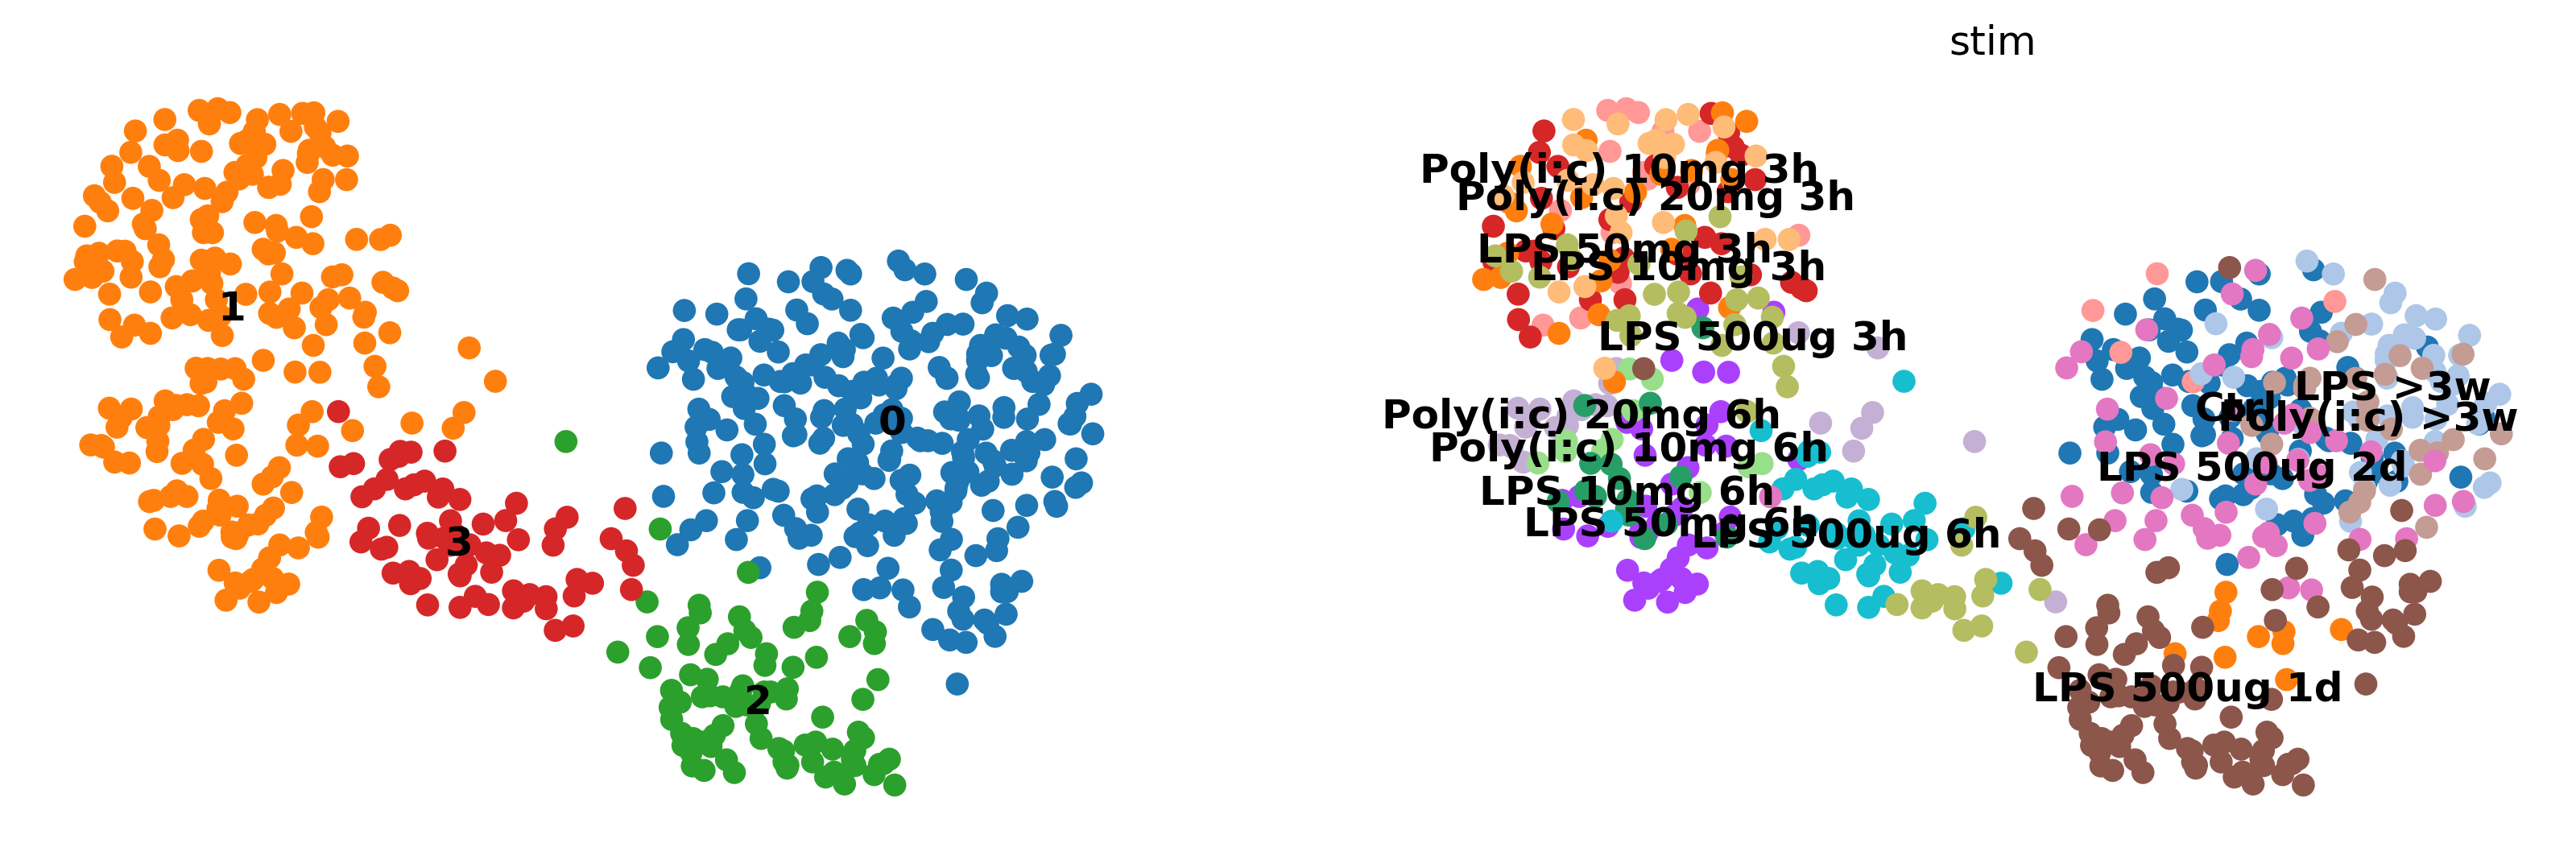

In [35]:
# plot umap to check
sc.pl.umap(cort, color=['leiden','stim'], frameon=False, legend_loc='on data', title='')

# Step 3: Computing RNA velocity using scVelo Dynamic model

In [36]:
sc.tl.pca(cort, svd_solver='arpack')
sc.pp.neighbors(cort, n_neighbors=15, use_rep='X_pca')
sc.tl.umap(cort)

In [37]:
# pre-process
scv.pp.filter_and_normalize(cort)
scv.pp.moments(cort)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [38]:
scv.tl.recover_dynamics(cort, n_jobs=16)

recovering dynamics (using 16/48 cores)


  0%|          | 0/379 [00:00<?, ?gene/s]

    finished (0:00:07) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [39]:
# compute velocity using the dynamical model (Bergen., 2020), i.e. mode='dynamical'
scv.tl.velocity(cort, mode='dynamical')
scv.tl.velocity_graph(cort)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/48 cores)


  0%|          | 0/636 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


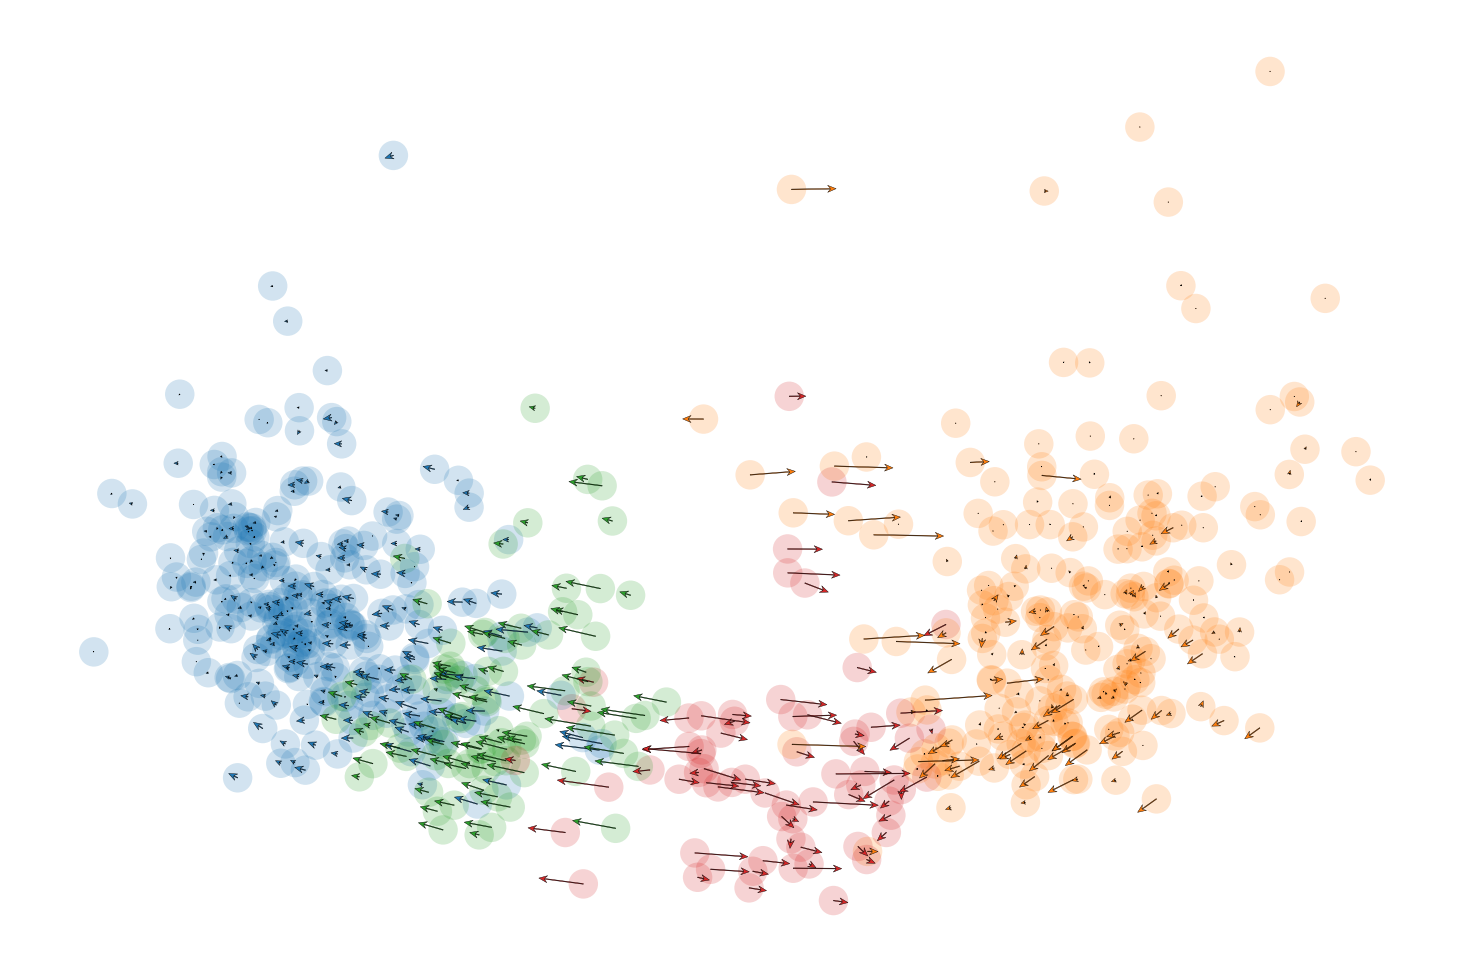

In [40]:
scv.pl.velocity_embedding(
    cort, basis='pca', color='leiden', title='', 
    size=200, arrow_size=1, legend_fontsize=20
)

saving figure to file ../figures/Fig5/cort_velo_embstream.svg


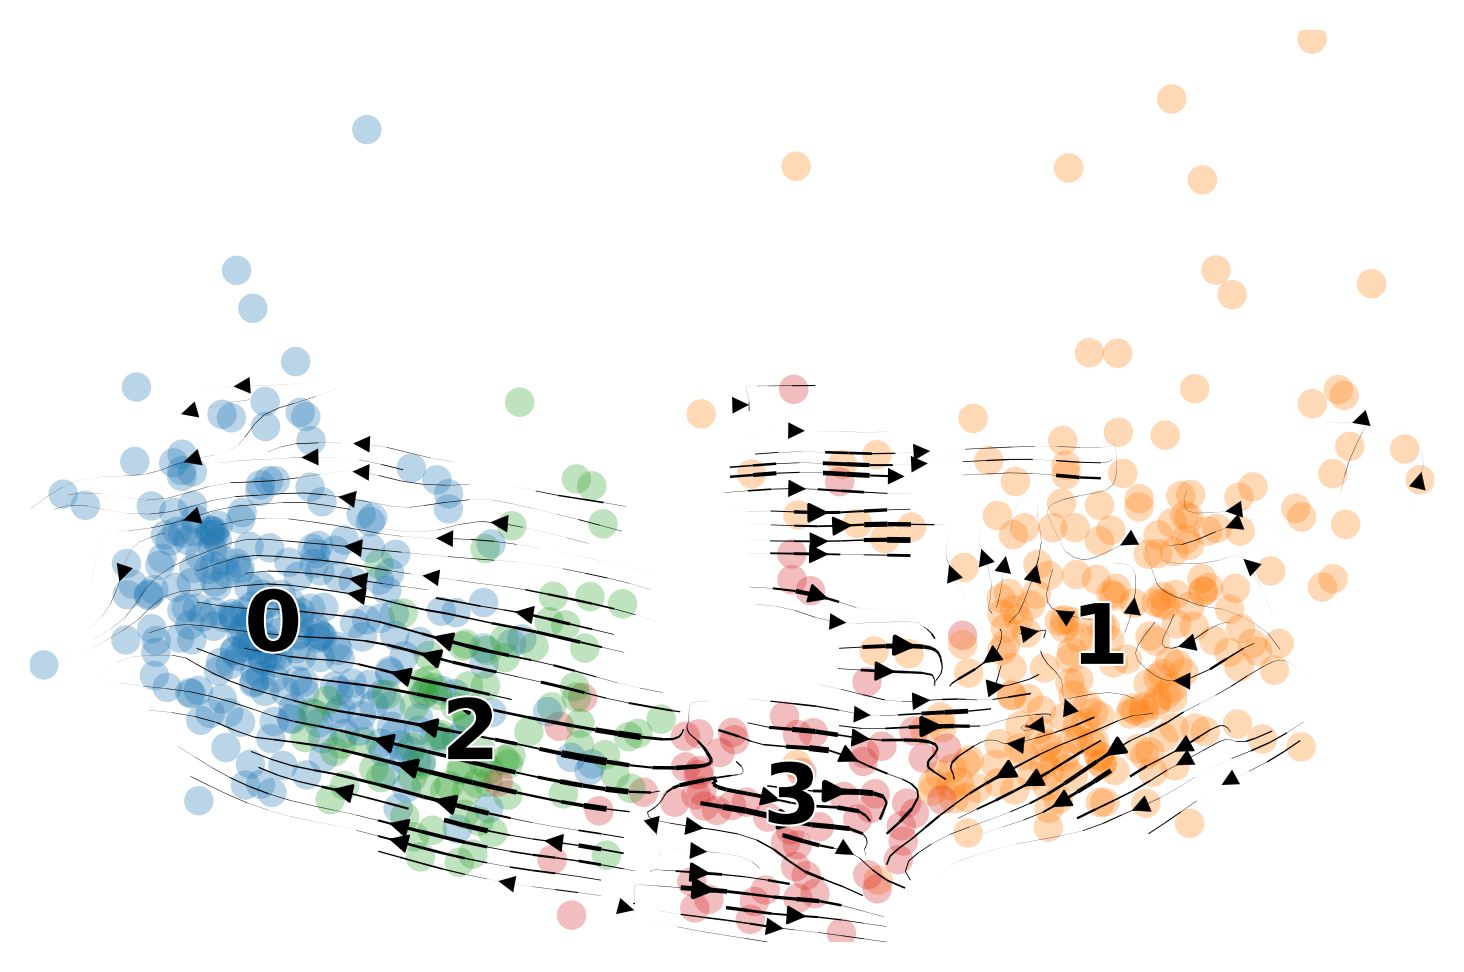

In [41]:
scv.pl.velocity_embedding_stream(
    cort, basis='pca', color='leiden', title='', 
    size=200, arrow_size=1, legend_fontsize=20,
    save='../figures/Fig5/cort_velo_embstream.svg'
)

### Kinetic rate parameters

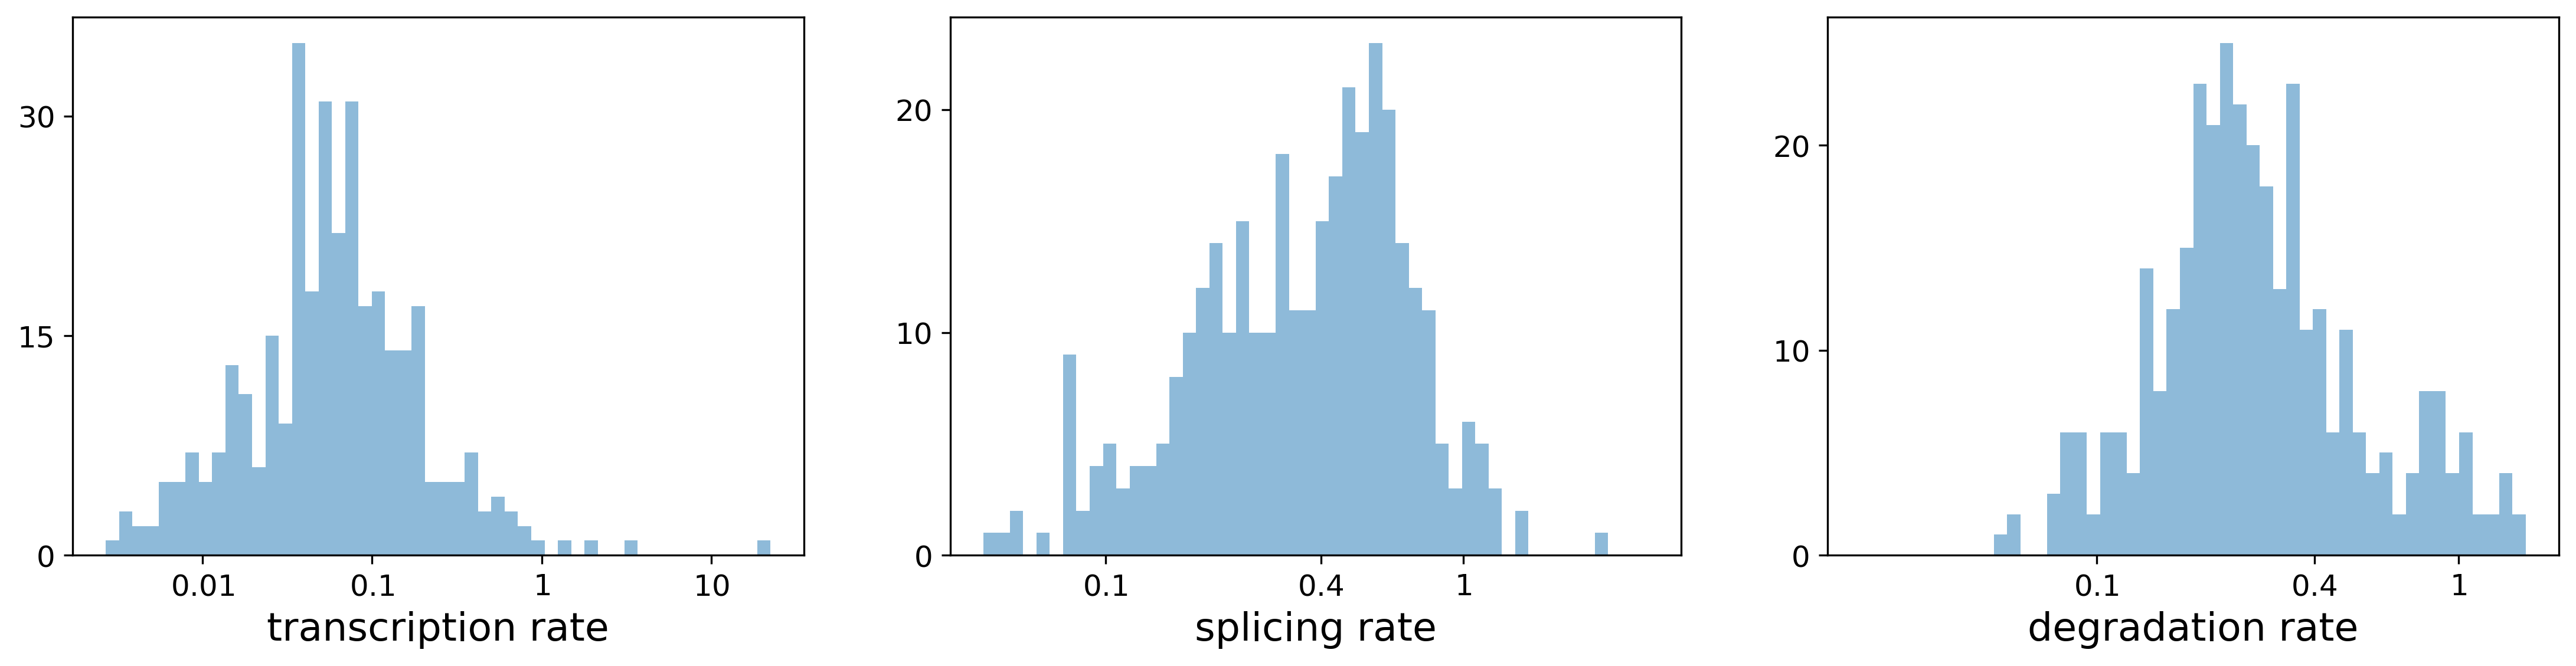

,fit_r2,fit_alpha,fit_beta,fit_gamma,fit_t_,fit_scaling,fit_std_u,fit_std_s,fit_likelihood,fit_u0,fit_s0,fit_pval_steady,fit_steady_u,fit_steady_s,fit_variance,fit_alignment_scaling
1110038B12Rik,0.069145,0.056845,1.399127,0.205391,18.699521,0.092597,0.013203,0.067372,0.212857,0.0,0.0,0.347412,0.039336,0.188218,0.992327,3.473418
1500035N22Rik,0.063317,0.077456,2.034627,0.345242,7.964673,0.274616,0.009976,0.055306,0.241061,0.0,0.0,0.082618,0.026754,0.151760,0.793610,2.595121
1700003E16Rik,0.024104,0.006880,0.128642,0.286032,31.488226,1.201307,0.015891,0.005953,0.287703,0.0,0.0,0.000693,0.041761,0.015643,0.740281,2.913433
2310033P09Rik,0.035504,0.139471,2.463046,0.168284,9.184162,0.274650,0.021025,0.126308,0.090405,0.0,0.0,0.396749,0.055739,0.448801,1.109742,2.530576
2700012I20Rik,0.062713,0.019006,0.449232,0.148331,27.609920,0.181440,0.010353,0.025677,0.175991,0.0,0.0,0.009273,0.031181,0.073048,0.486916,5.520882


In [42]:
df = cort.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(cort, 'fit*', dropna=True).head()

In [43]:
scv.get_df(cort, 'fit*', dropna=True).to_csv("../outs/scvelo/cort_kinetic_params.csv")

### Latent time

In [44]:
cort.uns['iroot'] = 2

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root cell 2 as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
saving figure to file ../figures/Fig5/cort_latent_time.pdf


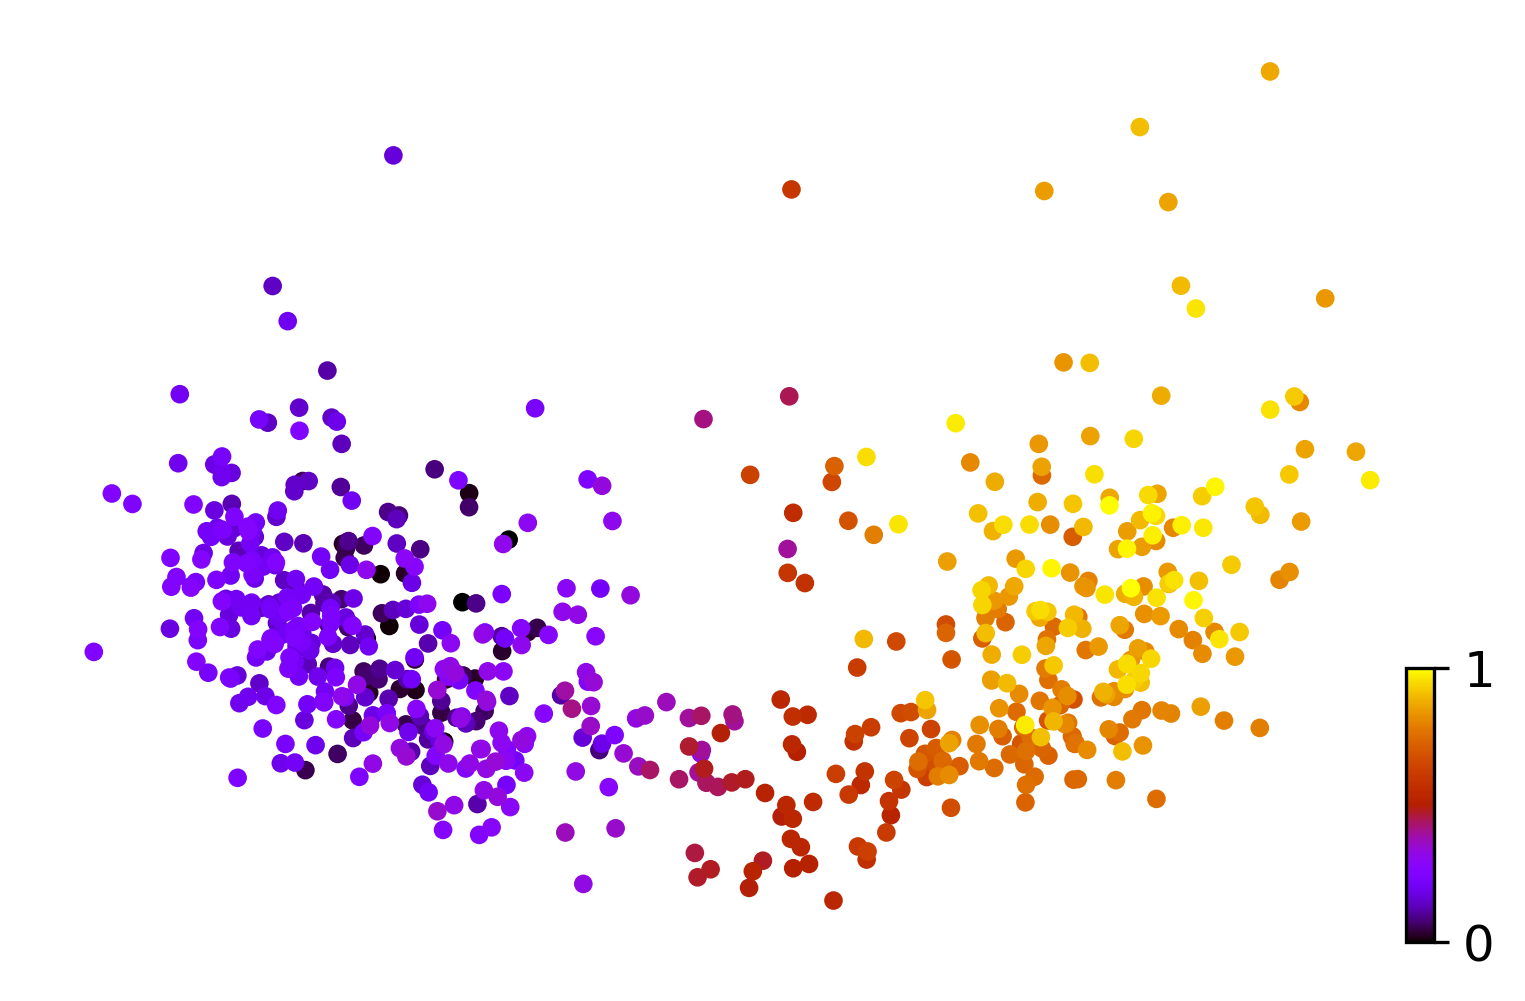

In [45]:
scv.tl.latent_time(cort, root_key='iroot')
scv.pl.scatter(cort, color='latent_time', color_map='gnuplot', size=80, basis='pca',
               title='', legend_fontsize=20,
              save='../figures/Fig5/cort_latent_time.pdf')

saving figure to file ../figures/Fig5/cort_latent_time_heatmap.pdf


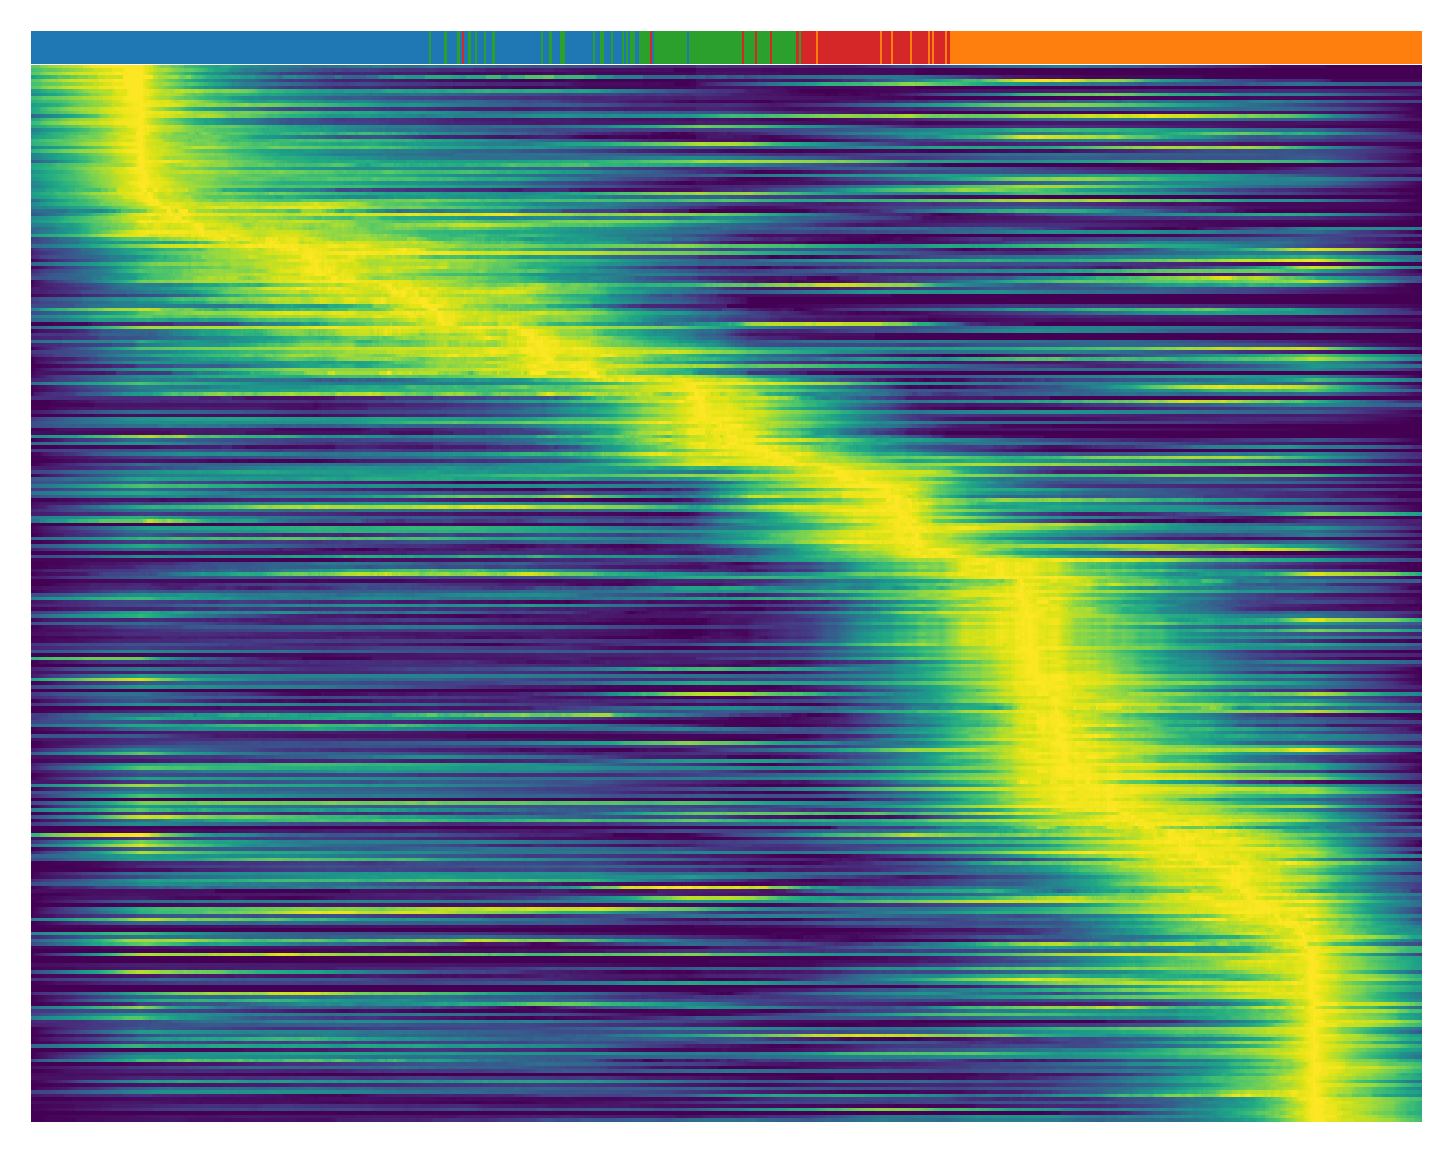

In [46]:
top_genes = cort.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(cort, var_names=top_genes, sortby='latent_time', col_color='leiden', 
               n_convolve=100, yticklabels=False, figsize=(5,4),
              save='../figures/Fig5/cort_latent_time_heatmap.pdf')

### Differential Kinetic Test

In [52]:
top_genes[120:140]

Index(['Gimap4', 'Nrsn2', 'Dcn', 'Odc1', 'Acad12', 'Uhmk1', 'Wnt10a', 'Tmco4',
       'Ehd4', 'Fam160b2', 'Ccl12', 'Mt3', '1500035N22Rik', 'Cdc42ep4',
       'A930016O22Rik', 'Trmt61b', 'Cep126', 'Plxdc2', 'Maml1', 'Ptpru'],
      dtype='object')

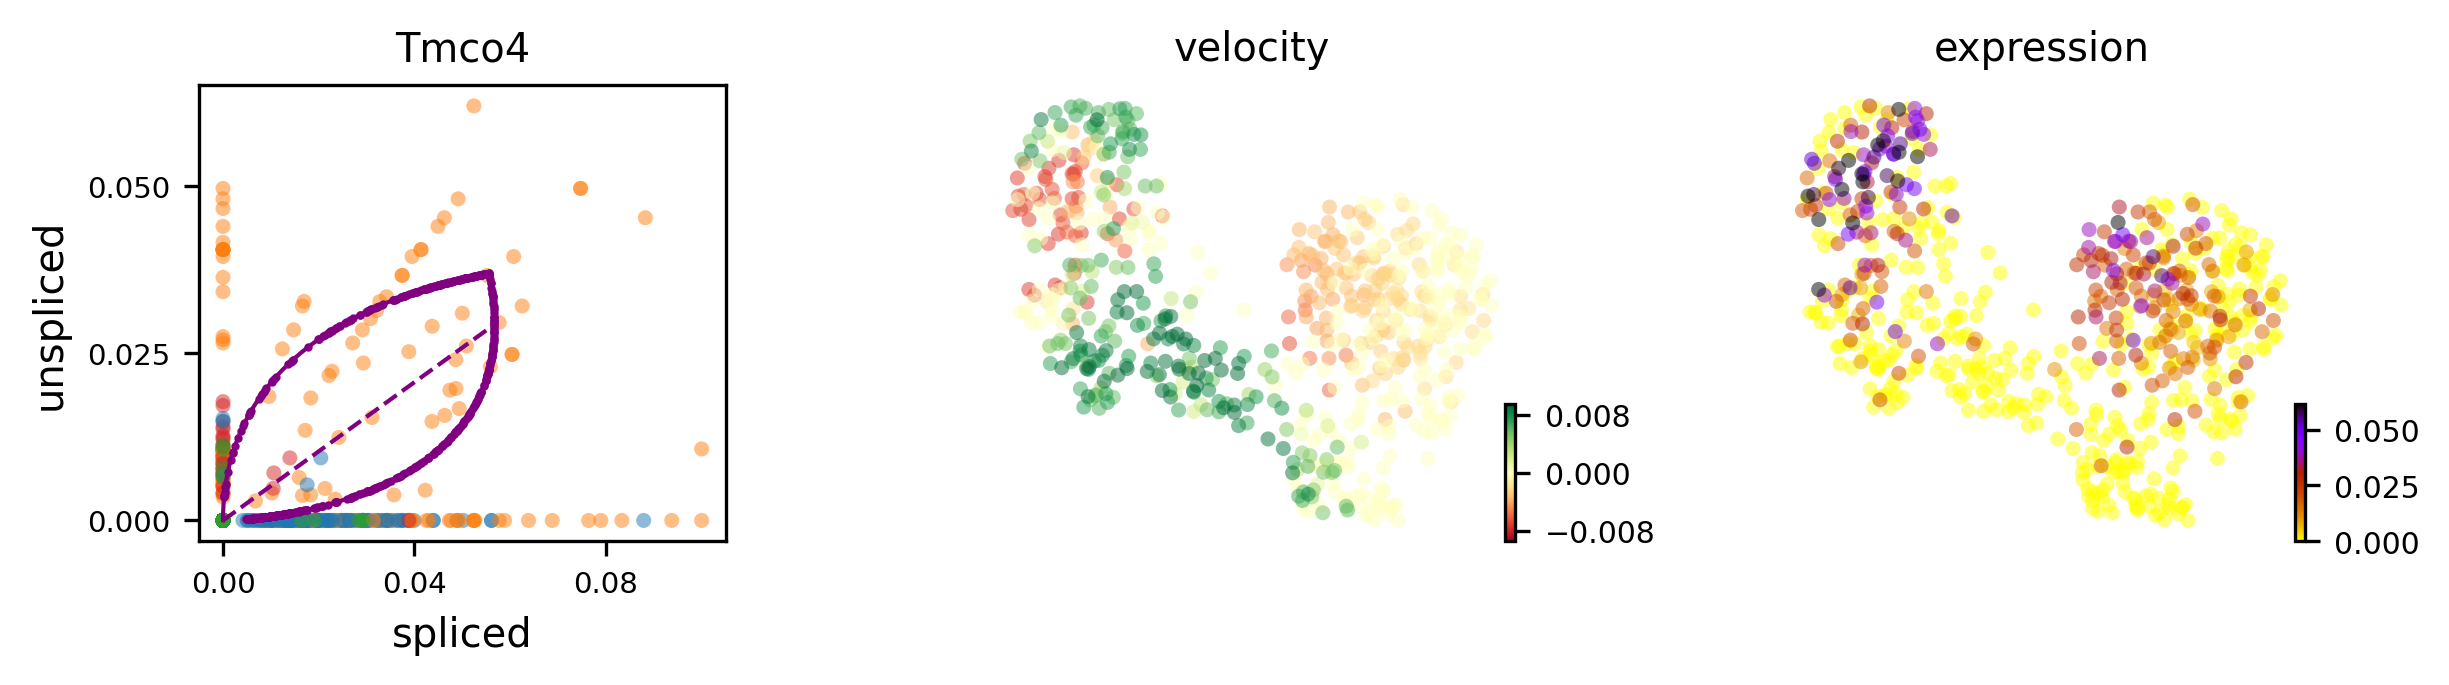

In [55]:
scv.pl.velocity(cort, ['Tmco4'], color='leiden')